In [13]:
# !pip3 install "gymnasium[atari, accept-rom-license]" opencv-python

In [39]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.autograd import Variable
from PIL import Image
import cv2
from torchvision.transforms import v2
import matplotlib.pyplot as plt

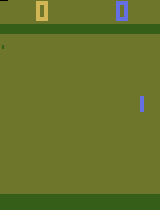

In [15]:
env = gym.make("ALE/Pong-v5")
env.obs_type = "grayscale"
observation, info = env.reset()
Image.fromarray(observation)

In [16]:
device = torch.device("cuda")

In [17]:
height = observation.shape[0]
width = observation.shape[1]
channels = observation.shape[2]

In [18]:
process = transforms.Compose([
    transforms.ToTensor()
])

In [19]:
observation = process(observation)
observation = observation.unsqueeze(0).to(device)

In [20]:
class Flatten(nn.Module):
    def forward(self, input):
        input = input.view(input.size(0), -1)
        return input

class UnFlatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), 256, 11, 8)

class VAE(nn.Module):
    def __init__(self, image_channels=3, height=height, width=width):
        super(VAE, self).__init__()

        self.height = height
        self.width = width
        
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=4, stride=2),
            nn.Sigmoid(),
        )

    def forward(self, x):
        l = self.encoder(x)
        # print(l.shape)
        l = Flatten().forward(l)
        # print(l.shape)
        l = UnFlatten().forward(l)
        # print(l.shape)
        return self.decoder(l)

# Model Initialization
model = VAE().to(device)
 
# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()
 
# Using an Adam Optimizer
optimizer = torch.optim.Adam(model.parameters())

In [21]:
print(observation.shape)
x_hat = model(observation)
print(x_hat.shape)

torch.Size([1, 3, 210, 160])
torch.Size([1, 3, 206, 158])


In [27]:
losses = []
for _ in range(10000):
    action = env.action_space.sample()  # agent policy that uses the observation and info
    observation, reward, terminated, truncated, info = env.step(action)

    observation = process(observation).unsqueeze(0).to(device)
    reconstruction = model(observation)
    loss = loss_function(reconstruction, observation[:, :, :206, :158])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss)

    if terminated or truncated:
        observation, info = env.reset()
env.close()

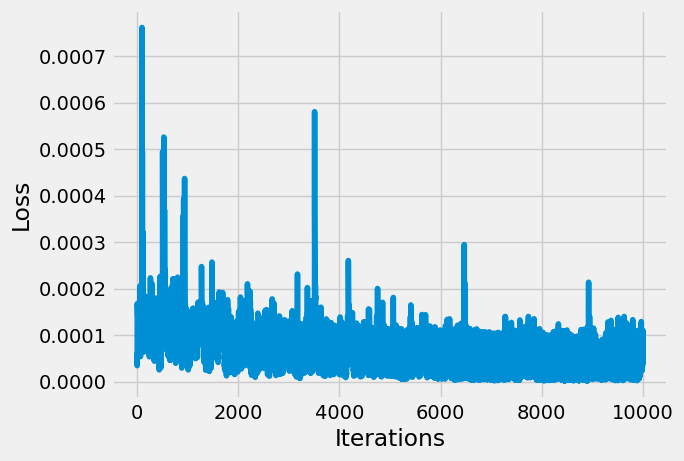

In [28]:
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')

num_losses = []

for x in losses:
    num_losses.append(x.item())

plt.plot(num_losses)

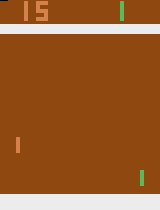

In [35]:
transforms.functional.to_pil_image(observation.view(3, height, width))

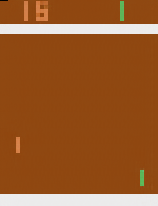

In [38]:
transforms.functional.to_pil_image(reconstruction.view(3, 206, 158))